In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import random
from datetime import timedelta
from pandas.tseries.offsets import DateOffset
from scipy.stats import percentileofscore, zscore
import ta
import os
from typing import List, Tuple, Optional, Literal
from datetime import datetime
from pydantic import BaseModel, Field, validator
from models import *


from backtest_optimizer.main import (
    ParameterOptimizer,
)

In [8]:

def mark_extremes_advanced(
    prices: List[float],
    threshold_abs: float = 0.0,
    threshold_pct: float = 0.03,
    use_pct: bool = True,
    dynamic_threshold: bool = False,
    vol_window: int = 10,
    vol_multiplier: float = 1.0,
    confirmation_period: int = 1,
) -> List[Tuple[int, str]]:
    """
    Identify turning points (peaks and troughs) in a price series using an advanced zigzag approach.

    In this version, a turning point is detected only after a reversal condition is confirmed
    for a number of consecutive bars (confirmation_period). In addition, the threshold for a reversal
    can be based on either a fixed percentage/absolute level or (optionally) be dynamically adjusted
    based on recent volatility.

    Parameters:
        prices (List[float]): List of price values.
        threshold_abs (float): Fixed absolute threshold (if use_pct is False).
        threshold_pct (float): Percentage threshold (e.g. 0.03 for 3%) used if use_pct is True.
        use_pct (bool): If True, the base threshold is computed as threshold_pct * current_price.
        dynamic_threshold (bool): If True, adjust the threshold based on recent volatility.
        vol_window (int): Number of bars to compute volatility if dynamic_threshold is True.
        vol_multiplier (float): Multiplier for volatility to form a dynamic threshold.
        confirmation_period (int): Number of consecutive bars that must confirm a reversal before marking it.

    Returns:
        List[Tuple[int, str]]: A list of tuples where each tuple is (index, type) and type is either 'peak' or 'trough'.
    """
    if not prices:
        return []

    turning_points: List[Tuple[int, str]] = []

    # Initialize extremes with the first price.
    last_min = prices[0]
    last_max = prices[0]
    last_min_idx = 0
    last_max_idx = 0

    # Trend indicator: True means an uptrend (so the last extreme was a minimum)
    # False means a downtrend (last extreme was a maximum). None means not yet established.
    trend = None

    i = 1
    n = len(prices)

    while i < n:
        price = prices[i]

        if dynamic_threshold:
            if i < vol_window:
                i += 1
                continue
            recent_changes = np.diff(prices[i - vol_window : i + 1])
            volatility = np.std(recent_changes)
            dynamic_thresh = vol_multiplier * volatility
            threshold = max(threshold_abs, dynamic_thresh)
        else:
            threshold = threshold_abs if not use_pct else threshold_pct * prices[i]
        # --- Update current extremes ---
        if price > last_max:
            last_max = price
            last_max_idx = i
        if price < last_min:
            last_min = price
            last_min_idx = i
        # --- Establish the initial trend if not set ---
        if trend is None:
            if last_max - prices[0] > threshold:
                trend = True  # Uptrend is established (price rose from the first bar)
            elif prices[0] - last_min > threshold:
                trend = False  # Downtrend is established
            # Else, trend remains undefined.
        # --- Check for reversal conditions with confirmation ---
        # In an uptrend, a sufficient drop from the last maximum signals a potential reversal.
        if trend is True and (last_max - price > threshold):
            confirm = True
            for j in range(i, min(i + confirmation_period, n)):
                if last_max - prices[j] <= threshold:
                    confirm = False
                    break
            if confirm:
                # In an uptrend, a drop signals that the previous maximum is a peak.
                turning_points.append((last_max_idx, "peak"))
                # Reset the minimum using the current price.
                last_min = prices[i]
                last_min_idx = i
                trend = False
                i += confirmation_period  # Skip confirmation period.
                continue

        # In a downtrend, a sufficient rise from the last minimum signals a potential reversal.
        if trend is False and (price - last_min > threshold):
            confirm = True
            for j in range(i, min(i + confirmation_period, n)):
                if prices[j] - last_min <= threshold:
                    confirm = False
                    break
            if confirm:
                turning_points.append((last_min_idx, "trough"))
                # Reset the maximum using the current price.
                last_max = prices[i]
                last_max_idx = i
                trend = True
                i += confirmation_period
                continue

        i += 1

    # Always mark the final point as a turning point if it wasn’t already included.
    if not turning_points or turning_points[-1][0] != n - 1:
        # For the final point, we decide its type based on the current trend.
        final_type = "trough" if trend else "peak"
        turning_points.append((n - 1, final_type))

    return turning_points


def expand_region(
    prices: List[float],
    extreme_index: int,
    extreme_type: str,
    region_tolerance_pct: float,
) -> Tuple[int, int]:
    """
    Given an extreme (turning point) at extreme_index with a given type ('peak' or 'trough'),
    expand outward to mark the region where the price remains close to the extreme value.

    For a 'peak', we include contiguous indices where the price is within (1 - region_tolerance_pct)
    of the peak value. For a 'trough', we include indices where the price is within (1 + region_tolerance_pct)
    of the trough value.

    Parameters:
        prices (List[float]): The price series.
        extreme_index (int): The index of the turning point.
        extreme_type (str): Either 'peak' or 'trough'.
        region_tolerance_pct (float): Tolerance as a fraction (e.g., 0.01 for 1%).

    Returns:
        Tuple[int, int]: A tuple (start_index, end_index) defining the region boundaries.
    """
    extreme_value = prices[extreme_index]
    start = extreme_index
    end = extreme_index
    n = len(prices)

    if extreme_type == "peak":
        # Expand left as long as the price is within region_tolerance_pct of the peak.
        while start > 0 and prices[start - 1] >= extreme_value * (
            1 - region_tolerance_pct
        ):
            start -= 1
        # Expand right similarly.
        while end < n - 1 and prices[end + 1] >= extreme_value * (
            1 - region_tolerance_pct
        ):
            end += 1
    elif extreme_type == "trough":
        while start > 0 and prices[start - 1] <= extreme_value * (
            1 + region_tolerance_pct
        ):
            start -= 1
        while end < n - 1 and prices[end + 1] <= extreme_value * (
            1 + region_tolerance_pct
        ):
            end += 1
    else:
        raise ValueError("extreme_type must be either 'peak' or 'trough'.")

    return start, end


def mark_extreme_regions(
    prices: List[float],
    threshold_abs: float = 0.0,
    threshold_pct: float = 0.03,
    use_pct: bool = True,
    dynamic_threshold: bool = False,
    vol_window: int = 10,
    vol_multiplier: float = 1.0,
    confirmation_period: int = 1,
    region_tolerance_pct: float = 0.01,
) -> List[Tuple[int, int, str]]:
    """
    First detect turning points using an advanced zigzag algorithm, then expand each turning point
    into a region where the price remains near the extreme value.

    Returns a list of tuples (region_start_index, region_end_index, type), where type is 'peak' or 'trough'.
    """
    # Detect turning points.
    turning_points = mark_extremes_advanced(
        prices,
        threshold_abs,
        threshold_pct,
        use_pct,
        dynamic_threshold,
        vol_window,
        vol_multiplier,
        confirmation_period,
    )
    regions = []
    for idx, t_type in turning_points:
        start, end = expand_region(prices, idx, t_type, region_tolerance_pct)
        regions.append((start, end, t_type))
    return regions


def detect_anomalies_agg_returns(
    df, L=10, rolling_window=50, threshold=3, method="sum"
):
    returns = df["close"].pct_change().fillna(0)
    if method == "sum":
        S = returns.rolling(window=L).sum()
    else:
        S = returns.rolling(window=L).mean()
    S = S.dropna()
    med = S.rolling(window=rolling_window, center=True).median()
    mad = S.rolling(window=rolling_window, center=True).apply(
        lambda x: np.median(np.abs(x - np.median(x))), raw=True
    )
    robust_z = (S - med) / (1.4826 * mad)
    agg_anomalies = S.index[np.abs(robust_z) > threshold]
    return agg_anomalies


def detect_anomalies(mse, num_std):
    """Detect anomalies in test data using thresholding."""
    threshold = np.mean(mse) + num_std * np.std(mse)
    # print("Threshold = ", np.round(threshold, 2))
    anomalies = np.where(mse > np.round(threshold, 2))[0]
    return anomalies


def deviation_from_mean(data, value):
    # z_scores = zscore(data)
    deviation = (value - np.mean(data)) / np.std(data)
    return deviation


def check_entry_signal(
    trade_type: str,
    current_rsi: float,
    current_price: float,
    current_ma_short: float,
    current_ma_long: float,
    rsi_entry: [list, tuple],
    exit_val: str,
    with_short: bool,
) -> bool:
    conditions = {
        ("buy", "rsi"): current_rsi < rsi_entry[0],
        ("buy", "ma"): current_price < current_ma_long,
        ("sell", "rsi"): (current_rsi > rsi_entry[1]) if with_short else False,
        ("sell", "ma"): (current_price > current_ma_short) if with_short else False,
    }
    return conditions.get((trade_type, exit_val), False)


class Trade(BaseModel):
    trade_type: Literal["buy", "sell"] = Field(..., description="Type of the trade")
    volume: float = Field(..., gt=0, description="Volume of the trade")
    entry_price: float = Field(
        ..., gt=0, description="Price at which the trade was entered"
    )
    entry_time: datetime = Field(
        ..., description="Timestamp when the trade was entered"
    )

    exit_time: Optional[datetime] = Field(
        None, description="Timestamp when the trade was closed"
    )
    exit_price: Optional[float] = Field(
        None, gt=0, description="Price at which the trade was closed"
    )
    profit: Optional[float] = Field(None, description="Profit or loss from the trade")

    @validator("entry_time", "exit_time", pre=True, always=True)
    def convert_np_datetime(cls, v):
        if isinstance(v, np.datetime64):
            # Convert numpy.datetime64 to Python datetime
            return pd.Timestamp(v).to_pydatetime()
        return v

    def close_trade(
        self, exit_time: datetime, exit_price: float, commission_rate: float
    ) -> None:
        """
        Closes the trade by setting the exit time, exit price, and calculating the profit.
        """
        self.exit_time = exit_time
        self.exit_price = exit_price

        if self.trade_type == "buy":
            raw_profit = (exit_price - self.entry_price) * (
                self.volume / self.entry_price
            )
        else:  # For "sell" trades
            raw_profit = (self.entry_price - exit_price) * (
                self.volume / self.entry_price
            )

        # Deduct commission from the profit
        self.profit = raw_profit - (self.volume * commission_rate)


# noinspection PyTypeChecker
def simulate_trading_std(
    model_name,
    price_data: pd.Series,
    scaled_prices: pd.Series,
    predicted_prices: pd.Series,
    ma_data_short: pd.Series,
    ma_data_long: pd.Series,
    rsi_data: pd.Series,
    scores,  # type unspecified
    rolling_anomalies,
    num_std: float,
    max_entries: int,
    exit_val,
    distr_len: int = 99,
    num_std_exit: float = 1,
    rsi_entry=(40, 60),
    rsi_exit=(60, 40),
    print_trades: bool = False,
    commission_rate: float = 0.0002,
    with_short: bool = True,
):
    """
    Simulates a trading strategy and returns a Pandas Series of daily profits and a list of closed Trade objects.
    """
    # Convert data to numpy arrays for fast access.
    price_array = price_data.to_numpy(dtype=np.float64)
    ma_array_short = ma_data_short.to_numpy(dtype=np.float64)
    ma_array_long = ma_data_long.to_numpy(dtype=np.float64)
    rsi_array = rsi_data.to_numpy(dtype=np.float64)
    scaled_prices_array = scaled_prices.to_numpy(dtype=np.float64)
    predicted_prices_array = predicted_prices.to_numpy(dtype=np.float64)
    anomalies_array = np.asarray(rolling_anomalies, dtype=bool)
    index_array = price_data.index.to_numpy()

    n = len(price_array)
    if len(rsi_array) != n or len(anomalies_array) != n:
        raise ValueError(
            "price_data, rsi_data, and rolling_anomalies must have the same length."
        )

    rolling_std = price_data.rolling(distr_len, min_periods=1).std().values

    capital = 1.0
    profit_array = np.full(n, np.nan, dtype=np.float64)
    open_trades: List[Trade] = []
    closed_trades: List[Trade] = []
    trade_entries = set()

    base_price = None
    base_trade_type = None

    def get_entry_signal(i: int) -> Optional[str]:
        if not anomalies_array[i]:
            return None

        current_price = price_array[i]
        current_rsi = rsi_array[i]
        current_ma_short = ma_array_short[i]
        current_ma_long = ma_array_long[i]
        scaled_price = scaled_prices_array[i]
        predicted_price = predicted_prices_array[i]

        buy_signal = check_entry_signal(
            trade_type="buy",
            current_rsi=current_rsi,
            current_price=current_price,
            current_ma_short=current_ma_short,
            current_ma_long=current_ma_long,
            rsi_entry=rsi_entry,
            exit_val=exit_val,
            with_short=with_short,
        )

        sell_signal = (
            check_entry_signal(
                trade_type="sell",
                current_rsi=current_rsi,
                current_price=current_price,
                current_ma_short=current_ma_short,
                current_ma_long=current_ma_long,
                rsi_entry=rsi_entry,
                exit_val=exit_val,
                with_short=with_short,
            )
            if with_short
            else False
        )

        return "buy" if buy_signal else "sell" if sell_signal else None

    for i in range(n):
        timestamp = index_array[i]
        current_price = price_array[i]
        current_ma_short = ma_array_short[i]
        current_ma_long = ma_array_long[i]
        current_rsi = rsi_array[i]
        local_std = rolling_std[i]
        daily_profit = 0.0

        # ----- Handle Trade Exits -----
        if open_trades:
            # Check for a trade flip (opening an opposite position)
            opposite_trade_type = "sell" if base_trade_type == "buy" else "buy"

            flip_signal = get_entry_signal(i) == opposite_trade_type

            if flip_signal:
                for trade in open_trades:
                    trade.close_trade(
                        exit_time=timestamp,
                        exit_price=current_price,
                        commission_rate=commission_rate,
                    )
                    capital += trade.profit
                    daily_profit += trade.profit
                    if print_trades:
                        print(
                            f"Trade flipped: {trade.trade_type} entered at {trade.entry_time} "
                            f"(Entry Price: {trade.entry_price:.2f}), exited at {timestamp} "
                            f"(Exit Price: {current_price:.2f}), Volume: {trade.volume:.4f}, "
                            f"P&L: {trade.profit:.4f}"
                        )
                    closed_trades.append(trade)
                open_trades = []
                base_price, base_trade_type = None, None

            # Check individual trade exit conditions
            trades_to_close = []
            for trade in open_trades:
                exit_signal = False

                if exit_val == "rsi":
                    if trade.trade_type == "buy" and current_rsi >= rsi_exit[0]:
                        exit_signal = True
                    elif trade.trade_type == "sell" and current_rsi <= rsi_exit[1]:
                        exit_signal = True
                elif exit_val == "ma":
                    if trade.trade_type == "buy" and current_price >= current_ma_long:
                        exit_signal = True
                    elif (
                        trade.trade_type == "sell" and current_price <= current_ma_short
                    ):
                        exit_signal = True

                # Standard deviation-based exit condition
                if (
                    trade.trade_type == "buy"
                    and current_price >= trade.entry_price + local_std * num_std_exit
                ):
                    exit_signal = True
                if (
                    trade.trade_type == "sell"
                    and current_price <= trade.entry_price - local_std * num_std_exit
                ):
                    exit_signal = True

                if exit_signal:
                    trades_to_close.append(trade)

            for trade in trades_to_close:
                trade.close_trade(
                    exit_time=timestamp,
                    exit_price=current_price,
                    commission_rate=commission_rate,
                )
                capital += trade.profit
                daily_profit += trade.profit
                if print_trades:
                    print(
                        f"Trade executed: {trade.trade_type} entered at {trade.entry_time} "
                        f"(Entry Price: {trade.entry_price:.2f}), exited at {timestamp} "
                        f"(Exit Price: {current_price:.2f}), Volume: {trade.volume:.4f}, "
                        f"P&L: {trade.profit:.4f}"
                    )
                closed_trades.append(trade)
            # Keep open trades that haven't met exit conditions
            open_trades = [
                trade for trade in open_trades if trade not in trades_to_close
            ]

        # ----- Handle Trade Entries -----
        entry_signal = get_entry_signal(i)
        if entry_signal and len(open_trades) < max_entries:
            if not open_trades:
                if timestamp not in trade_entries:
                    trade_entries.add(timestamp)
                    trade_volume = capital / max_entries
                    new_trade = Trade(
                        trade_type=entry_signal,
                        volume=trade_volume,
                        entry_price=current_price,
                        entry_time=timestamp,
                    )
                    open_trades.append(new_trade)
                    base_price = current_price
                    base_trade_type = entry_signal
            else:
                required_distance = len(open_trades) * num_std * local_std
                price_condition = (
                    current_price >= base_price + required_distance
                    if base_trade_type == "sell"
                    else current_price <= base_price - required_distance
                )

                if price_condition and timestamp not in trade_entries:
                    trade_entries.add(timestamp)
                    trade_volume = capital / max_entries
                    new_trade = Trade(
                        trade_type=base_trade_type,
                        volume=trade_volume,
                        entry_price=current_price,
                        entry_time=timestamp,
                    )
                    open_trades.append(new_trade)

        profit_array[i] = daily_profit

    profits = pd.Series(profit_array, index=price_data.index).fillna(0)
    return profits, closed_trades


def simulate_trading_percentile(
    model_name,
    price_data,
    ma_data,
    scores,
    rolling_percentiles,
    rolling_anomalies,
    percentile,
    max_entries,
):
    initial_capital = 1.0
    capital = initial_capital
    capital_history = pd.Series(index=price_data.index, data=np.nan)
    capital_history.iloc[0] = capital

    open_trades = []
    trade_entries = set()  # Timestamps where trades are opened

    index_array = list(price_data.index)

    for i in range(len(index_array)):
        timestamp = index_array[i]

        current_price = price_data.iloc[i]
        current_ma = ma_data.iloc[i]

        trades_to_close = []
        for trade in open_trades:
            trade_type = trade["type"]
            entry_price = trade["entry_price"]
            entry_time = trade["entry_time"]
            anomaly_percentage = trade["anomaly_percentage"]
            if trade_type == "buy" and current_price >= current_ma:
                exit_price = current_price
                profit = (exit_price - entry_price) * (trade["volume"] / entry_price)
                capital += profit
                trades_to_close.append(trade)
                capital_history.iloc[i] = capital

                print(
                    f"Trade executed: {trade_type} at {entry_time} "
                    f"(Entry Price: {entry_price:.2f}), exited at {timestamp} "
                    f"(Exit Price: {exit_price:.2f}), Volume: {trade['volume']:.4f}, "
                    f"Anomaly: {anomaly_percentage:.2f}%, P&L: {profit:.4f}"
                )

            elif trade_type == "sell" and current_price <= current_ma:
                exit_price = current_price
                profit = (entry_price - exit_price) * (trade["volume"] / entry_price)
                capital += profit
                trades_to_close.append(trade)
                capital_history.iloc[i] = capital

                print(
                    f"Trade executed: {trade_type} at {entry_time} "
                    f"(Entry Price: {entry_price:.2f}), exited at {timestamp} "
                    f"(Exit Price: {exit_price:.2f}), Volume: {trade['volume']:.4f}, "
                    f"Anomaly: {anomaly_percentage:.2f}%, P&L: {profit:.4f}"
                )

        for closed_trade in trades_to_close:
            open_trades.remove(closed_trade)

        if rolling_anomalies[i] and len(open_trades) < max_entries:
            k = len(open_trades)
            required_threshold = percentile + k * step
            if required_threshold >= 100.0:
                required_threshold = 100.1

            anomaly_percentile = rolling_percentiles[i]
            if anomaly_percentile >= required_threshold:
                if timestamp not in trade_entries:
                    trade_entries.add(timestamp)
                    if current_price > current_ma:
                        trade_type = "sell"
                    elif current_price < current_ma:
                        trade_type = "buy"
                    else:
                        trade_type = None

                    if trade_type is not None:
                        trade_volume = capital / max_entries
                        anomaly_percentage = 100.0 - anomaly_percentile
                        open_trades.append(
                            {
                                "type": trade_type,
                                "volume": trade_volume,
                                "entry_price": current_price,
                                "entry_time": timestamp,
                                "anomaly_percentage": anomaly_percentage,
                            }
                        )

        capital_history.iloc[i] = capital

    capital_history.ffill(inplace=True)
    capital_history.fillna(capital, inplace=True)

    return capital_history


def calculate_rsi(df, window=14):
    rsi = ta.momentum.RSIIndicator(close=df["close"], window=window)
    rsi_values = rsi.rsi()
    rsi_values = np.maximum(rsi_values, 0)  # Ensure non-negative
    return rsi_values


def analyze_anomalies(
    anomaly_timestamps, original_data_sorted, window_minutes=13 * 24 * 60
):
    results = []

    for ts in anomaly_timestamps:
        if ts < original_data_sorted.index[window_minutes - 1]:
            continue

        future_time = ts + pd.Timedelta(hours=1)
        if future_time > original_data_sorted.index[-1]:
            continue

        try:
            open_price = original_data_sorted.loc[ts, "close"]
        except KeyError:
            continue

        prev_time = ts - pd.Timedelta(minutes=1)
        if prev_time not in original_data_sorted.index:
            continue
        rolling_avg = original_data_sorted.loc[prev_time, "rolling_avg"]
        rolling_low = original_data_sorted.loc[prev_time, "rolling_low"]
        rolling_high = original_data_sorted.loc[prev_time, "rolling_high"]

        if np.isnan(rolling_avg) or np.isnan(rolling_low) or np.isnan(rolling_high):
            continue

        above_avg = open_price > rolling_avg

        above_low = open_price > rolling_low
        below_high = open_price < rolling_high

        try:
            next_hour_data = original_data_sorted.loc[
                ts + pd.Timedelta(minutes=1) : ts + pd.Timedelta(hours=1)
            ]
        except KeyError:
            continue

        if next_hour_data.empty:
            continue

        min_open_next_hour = next_hour_data["close"].min()
        max_open_next_hour = next_hour_data["close"].max()

        try:
            close_price_next_hour = original_data_sorted.loc[
                ts + pd.Timedelta(hours=1), "close"
            ]
        except KeyError:
            continue

        if above_avg:
            price_after = min_open_next_hour
            price_change = min_open_next_hour - open_price
            direction = "Min"
        else:
            price_after = max_open_next_hour
            price_change = max_open_next_hour - open_price
            direction = "Max"

        close_change = close_price_next_hour - open_price

        price_change_pct = (price_change / open_price) * 100
        close_change_pct = (close_change / open_price) * 100

        if above_avg:
            if price_after < open_price:
                sign = 1
            elif price_after > open_price:
                sign = -1
            else:
                sign = 0
        else:
            if price_after > open_price:
                sign = 1
            elif price_after < open_price:
                sign = -1
            else:
                sign = 0

        price_change_pct_signed = price_change_pct * sign
        close_change_pct_signed = close_change_pct * sign

        relative_to_avg = "Above Avg" if above_avg else "Below Avg"
        relative_to_low_high = []
        if above_low:
            relative_to_low_high.append("Above Low")
        if below_high:
            relative_to_low_high.append("Below High")
        if not relative_to_low_high:
            relative_to_low_high.append("At Low/High")

        results.append(
            {
                "timestamp": ts,
                "open_price": open_price,
                "rolling_avg": rolling_avg,
                "rolling_low": rolling_low,
                "rolling_high": rolling_high,
                "relative_to_avg": relative_to_avg,
                "relative_to_low_high": ", ".join(relative_to_low_high),
                "price_after": price_after,
                "price_change_pct_signed": price_change_pct_signed,
                "direction": direction,
                "close_next_hour": close_price_next_hour,
                "close_change_pct_signed": close_change_pct_signed,
            }
        )

    results_df = pd.DataFrame(results)
    return results_df


def compute_statistics(results_df, model_name):
    if results_df.empty:
        print("No anomalies to analyze.")
        return

    print(f"\n=== Statistics for {model_name.capitalize()} ===")

    relative_to_avg = results_df["relative_to_avg"]
    print(f"\nRelative to {window_minutes}-minutes Average:")
    print(relative_to_avg.value_counts())

    relative_to_low_high = results_df["relative_to_low_high"]
    print(f"\nRelative to {window_minutes}-minutes Low/High:")
    print(relative_to_low_high.value_counts())

    print("\nNext Hour Min/Max Open Price Change (%):")
    print(results_df["price_change_pct_signed"].describe())

    print("\nNext Hour Close Price Change (%):")
    print(results_df["close_change_pct_signed"].describe())

    plt.figure(figsize=(10, 5))
    relative_to_avg.value_counts().plot(kind="bar")
    plt.title(
        f"{model_name.capitalize()} - Relative to {window_minutes}-minutes Average"
    )
    plt.xlabel("Position")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(10, 5))
    relative_to_low_high.value_counts().plot(kind="bar")
    plt.title(
        f"{model_name.capitalize()} - Relative to {window_minutes}-minutes Low/High"
    )
    plt.xlabel("Position")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(10, 5))
    results_df["price_change_pct_signed"].hist(bins=30)
    plt.title(
        f"{model_name.capitalize()} - Next Hour Min/Max Open Price Change (%) Distribution"
    )
    plt.xlabel("Price Change (%)")
    plt.ylabel("Frequency")
    plt.show()

    plt.figure(figsize=(10, 5))
    results_df["close_change_pct_signed"].hist(bins=30)
    plt.title(
        f"{model_name.capitalize()} - Next Hour Close Price Change (%) Distribution"
    )
    plt.xlabel("Price Change (%)")
    plt.ylabel("Frequency")
    plt.show()

def calc_pl(data_dict, params):
    results_dict = {}

    num_std = params.get("num_std", 1)
    num_std_exit = params.get("num_std_exit", 1)
    percentile = params.get("percentile", 99.5)
    exit_val = params.get("exit_val", "rsi")
    max_entries = params.get("max_entries", 5)
    plot_pl = params.get("plot_pl", False)
    distr_len = params.get("distr_len", 99)
    ma_window_short = params.get("ma_window_short", 100)
    ma_window_long = params.get("ma_window_long", 200)
    RSI_window_minutes = params.get("RSI_window_minutes", 500)
    window_size_minutes = params["window_size_minutes"]
    rsi_entry = (
        int(params["rsi_entry"].split(",")[0]),
        int(params["rsi_entry"].split(",")[1]),
    )
    rsi_exit = (
        int(params["rsi_exit"].split(",")[0]),
        int(params["rsi_exit"].split(",")[1]),
    )
    max_entries = params.get("max_entries", 5)
    print_trades = params.get("print_trades", False)
    comission_rate = params.get("comission_rate", 0.0002)
    with_short = params.get("with_short", True)

    for ticker, df in data_dict.items():
        if print_trades:
            print(f"\n=== Processing Ticker: {ticker} ===")
        price_data = df["close"]
        scaled_prices = df["scaled_price"]
        predicted_prices = df["predicted_price"]
        rsi_data = calculate_rsi(df, window=RSI_window_minutes)
        ma_data_short = (
            df["close"].rolling(window=ma_window_short, min_periods=1).mean()
        )
        ma_data_long = df["close"].rolling(window=ma_window_long, min_periods=1).mean()
        scores = df["scores"].values  # array

        rolling_anomalies = np.zeros_like(scores, dtype=bool)

        for i in range(window_size_minutes, len(scores)):
            start_idx = i - window_size_minutes
            end_idx = i
            window_slice = scores[start_idx:end_idx]
            current_score = scores[i]

            rank = percentileofscore(window_slice, current_score, kind="rank")
            if rank >= percentile:
                rolling_anomalies[i] = True
        if print_trades:
            print(rolling_anomalies.sum())
        profits, closed_trades = simulate_trading_std(
            model_name="kan",
            price_data=price_data,
            scaled_prices=scaled_prices,
            predicted_prices=predicted_prices,
            ma_data_short=ma_data_short,
            ma_data_long=ma_data_long,
            rsi_data=rsi_data,
            scores=scores,
            rolling_anomalies=rolling_anomalies,
            num_std=num_std,
            max_entries=max_entries,
            exit_val=exit_val,
            distr_len=distr_len,
            num_std_exit=num_std_exit,
            rsi_entry=rsi_entry,
            rsi_exit=rsi_exit,
            print_trades=print_trades,
            commission_rate=comission_rate,
            with_short=with_short,
        )

        if plot_pl:
            plt.figure(figsize=(12, 5))
            plt.plot(profits.index, profits.cumsum(), label="Profits history")
            plt.title(f"P&L Curve for {ticker} (exit_val={exit_val})")
            plt.xlabel("Date")
            plt.ylabel("Returns")
            plt.legend()
            plt.show()

        daily_rets = profits.resample("D").sum()

        results_dict[ticker] = daily_rets

    combined_returns = pd.concat(results_dict.values(), axis=1).sum(axis=1)
    return combined_returns  # , closed_trades, rolling_anomalies  #######


def calculate_sharpe_ratio(profits, risk_free_rate=0.0, annualization_factor=365):
    # Convert profits to daily returns
    daily_returns = profits.resample("D").sum()

    # Calculate mean and standard deviation of daily returns
    excess_returns = daily_returns - risk_free_rate  # Subtract risk-free rate if needed
    mean_return = excess_returns.mean()
    std_return = excess_returns.std()

    # Avoid division by zero in case of zero volatility
    if std_return == 0:
        return np.nan

    # Compute Sharpe Ratio (annualized)
    sharpe_ratio = (mean_return / std_return) * np.sqrt(annualization_factor)

    return sharpe_ratio

/tmp/ipykernel_1954/4191657188.py:280: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  @validator("entry_time", "exit_time", pre=True, always=True)


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

file_path = (
    "/Users/alexanderdemachev/PycharmProjects/strategy/data/futures/1min/BTCUSDT.csv"
)
preds_path = "/Users/alexanderdemachev/PycharmProjects/strategy/aq/portfolio_optimization/market_regimes/trading_models/anomaly/results/"

file_path = "BTCUSDT.csv"
preds_path = "results/"


sequence_length = 100
start_date = pd.Timestamp("2020-01-01 00:00:00")
end_date = pd.Timestamp("2024-12-20 23:59:00")
# window_days = 55
window_minutes = 500  # for rolling mean
exit_val = "ma"
percentile = 99.5
max_entries = 5
step = (100 - percentile) / max_entries
mode = "std"  #'std'/'percentile'
num_std = 1
num_std_anomaly = 3

window_size_minutes = 1000  # window for final anomalies distribution


data = pd.read_csv(file_path)

data["datetime"] = pd.to_datetime(data["datetime"])
data.set_index("datetime", inplace=True)

original_data_sorted = data[["open", "close"]].copy().sort_index()

original_data_sorted["rolling_avg"] = (
    original_data_sorted["close"].rolling(window=window_minutes).mean()
)
original_data_sorted["rolling_low"] = (
    original_data_sorted["close"].rolling(window=window_minutes).min()
)
original_data_sorted["rolling_high"] = (
    original_data_sorted["close"].rolling(window=window_minutes).max()
)
original_data_sorted["rsi"] = calculate_rsi(original_data_sorted, window=window_minutes)

# model_names = ['autoencoder', 'cnnautoencoder', 'lstm', 'cnn', 'stackvaeg', 'omnianomaly', 'egads', 'kan'] ######
model_names = ["autoencoder"]
model_params = {
    "autoencoder": {"input_size": sequence_length * 1, "hidden_dims": [64, 32, 16]},
    "lstm": {"input_size": 1, "hidden_size": 32, "num_layers": 1},
    "cnn": {"input_size": sequence_length, "out_channels": 16, "kernel_size": 3},
    "stackvaeg": {
        "input_size": sequence_length * 1,
        "hidden_dims": [64, 32],
        "latent_dim": 16,
    },
    "omnianomaly": {
        "input_size": 1,
        "hidden_size": 32,
        "latent_dim": 16,
        "num_layers": 1,
    },
    "egads": {"window": 30},
    "dtw": {"window": 30, "n_references": 10, "seed": 42},
    "cnnautoencoder": {
        "input_channels": 1,
        "sequence_length": sequence_length,
        "hidden_dims": [32, 16],
    },
    "kan": {
        "in_feat": 1,
        "hidden_feat": 64,
        "out_feat": 1,
        "num_layers": 2,
        "use_bias": True,
        "dropout": 0.3,
    },
}

train_initial_length = pd.DateOffset(months=6)
train_expand_step = pd.DateOffset(months=3)
test_length = pd.DateOffset(months=3)

window_size = 10000  # or whatever your desired rolling window is

data["rolling_min"] = data["close"].rolling(window=window_size, min_periods=1).min()
data["rolling_max"] = data["close"].rolling(window=window_size, min_periods=1).max()

data["scaled_price"] = (data["close"] - data["rolling_min"]) / (
    data["rolling_max"] - data["rolling_min"]
)
data["scaled_price"].fillna(method="bfill", inplace=True)
data = data.drop(columns=["rolling_min", "rolling_max"])

combined_test_dates = []
combined_scores = {}
combined_predictions = {}
combined_anomalies = {}
original_prices_buffer = []
scaled_prices = []

for model_name in model_names:
    combined_scores[model_name] = []
    combined_anomalies[model_name] = []
    combined_predictions[model_name] = []

current_train_start = start_date
current_train_end = current_train_start + train_initial_length
current_test_start = current_train_end
current_test_end = current_test_start + test_length

cuda


/tmp/ipykernel_1954/1544693184.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)
/tmp/ipykernel_1954/1544693184.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["scaled_price"].fillna(method="bfill", inplace=True)
/tmp/ipykernel_1954/1544693184.py:93: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["scaled_price"].fillna(method="bfill", inp

In [14]:
window_idx = 0

while current_test_end <= end_date or current_test_start < end_date:
    if current_test_end > end_date:
        current_test_end = end_date
    print(
        f"\n=== Processing Window: Train {current_train_start} to {current_train_end}, "
        f"Test {current_test_start} to {current_test_end} ==="
    )

    train_data = data.loc[current_train_start:current_train_end]
    test_data = data.loc[current_test_start:current_test_end]

    if test_data.empty:
        break

    train_scaled = train_data["scaled_price"].to_numpy().reshape(-1, 1)
    test_scaled = test_data["scaled_price"].to_numpy().reshape(-1, 1)

    original_prices_buffer.extend(test_data["close"].values[sequence_length:])
    scaled_prices.extend(test_scaled[sequence_length:, 0])

    train_torch = torch.tensor(train_scaled, dtype=torch.float32)
    test_torch = torch.tensor(test_scaled, dtype=torch.float32)

    train_sequences = create_sequences(train_torch, sequence_length)
    test_sequences = create_sequences(test_torch, sequence_length)
    test_dates = test_data.index[sequence_length:]
    combined_test_dates.extend(test_dates)

    for model_name in model_names:
        print(f"\n=== Processing Model: {model_name} ===")

        params = model_params[model_name]
        detector = AnomalyDetector(
            model_name=model_name,
            model_params=params,
            sequence_length=sequence_length,
            device=device
        )

        if model_name not in ['egads', 'dtw']:
            detector.train(
                train_sequences=train_sequences,
                num_epochs=10,
                batch_size=32,
                learning_rate=1e-3
            )

        torch.save(
                detector.model.state_dict(),
                f"{model_name}_window_{window_idx}.pth"
            )

        if model_name == 'egads':
            detector.train(
                train_sequences=None,
                train_raw=train_torch
            )
        elif model_name == 'dtw':
            detector.train(
                train_sequences=train_sequences,
                num_epochs=0,
                batch_size=0,
                learning_rate=0,
                train_raw=None
            )

        if model_name not in ['egads', 'dtw']:
            scores, preds = detector.predict(test_sequences=test_sequences)
        elif model_name == 'egads':
            scores, _ = detector.predict(test_raw=test_torch)
            preds = np.zeros_like(scores)
            scores = scores[sequence_length:]
            preds = preds[sequence_length:]
        elif model_name == 'dtw':
            scores, _ = detector.predict(test_sequences=test_sequences)
            preds = np.zeros_like(scores)

        combined_scores[model_name].extend(scores)
        combined_predictions[model_name].extend(preds)

    window_idx += 1

    current_train_end += train_expand_step
    current_test_start += train_expand_step
    current_test_end = current_test_start + test_length


=== Processing Window: Train 2020-01-01 00:00:00 to 2020-07-01 00:00:00, Test 2020-07-01 00:00:00 to 2020-10-01 00:00:00 ===

=== Processing Model: autoencoder ===


Training autoencoder:  10%|█         | 1/10 [00:08<01:18,  8.68s/it]

Epoch 1/10, Loss: 0.002747


Training autoencoder:  20%|██        | 2/10 [00:17<01:09,  8.69s/it]

Epoch 2/10, Loss: 0.000977


Training autoencoder:  30%|███       | 3/10 [00:26<01:00,  8.68s/it]

Epoch 3/10, Loss: 0.000871


Training autoencoder:  40%|████      | 4/10 [00:34<00:51,  8.66s/it]

Epoch 4/10, Loss: 0.000768


Training autoencoder:  50%|█████     | 5/10 [00:43<00:43,  8.66s/it]

Epoch 5/10, Loss: 0.000762


Training autoencoder:  60%|██████    | 6/10 [00:51<00:34,  8.64s/it]

Epoch 6/10, Loss: 0.000702


Training autoencoder:  70%|███████   | 7/10 [01:00<00:25,  8.62s/it]

Epoch 7/10, Loss: 0.000676


Training autoencoder:  80%|████████  | 8/10 [01:09<00:17,  8.63s/it]

Epoch 8/10, Loss: 0.000643


Training autoencoder:  90%|█████████ | 9/10 [01:17<00:08,  8.64s/it]

Epoch 9/10, Loss: 0.000634


Training autoencoder: 100%|██████████| 10/10 [01:26<00:00,  8.65s/it]

Epoch 10/10, Loss: 0.000633



=== Processing Window: Train 2020-01-01 00:00:00 to 2020-10-01 00:00:00, Test 2020-10-01 00:00:00 to 2021-01-01 00:00:00 ===

=== Processing Model: autoencoder ===


Training autoencoder:  10%|█         | 1/10 [00:12<01:56, 12.95s/it]

Epoch 1/10, Loss: 0.002908


Training autoencoder:  20%|██        | 2/10 [00:26<01:44, 13.11s/it]

Epoch 2/10, Loss: 0.000965


Training autoencoder:  30%|███       | 3/10 [00:39<01:31, 13.14s/it]

Epoch 3/10, Loss: 0.000857


Training autoencoder:  40%|████      | 4/10 [00:52<01:18, 13.09s/it]

Epoch 4/10, Loss: 0.000770


Training autoencoder:  50%|█████     | 5/10 [01:05<01:04, 12.95s/it]

Epoch 5/10, Loss: 0.000743


Training autoencoder:  60%|██████    | 6/10 [01:17<00:51, 12.85s/it]

Epoch 6/10, Loss: 0.000740


Training autoencoder:  70%|███████   | 7/10 [01:30<00:38, 12.84s/it]

Epoch 7/10, Loss: 0.000739


Training autoencoder:  80%|████████  | 8/10 [01:43<00:25, 12.82s/it]

Epoch 8/10, Loss: 0.000738


Training autoencoder:  90%|█████████ | 9/10 [01:56<00:12, 12.81s/it]

Epoch 9/10, Loss: 0.000737


Training autoencoder: 100%|██████████| 10/10 [02:09<00:00, 12.93s/it]

Epoch 10/10, Loss: 0.000737



=== Processing Window: Train 2020-01-01 00:00:00 to 2021-01-01 00:00:00, Test 2021-01-01 00:00:00 to 2021-04-01 00:00:00 ===

=== Processing Model: autoencoder ===


Training autoencoder:  10%|█         | 1/10 [00:17<02:38, 17.58s/it]

Epoch 1/10, Loss: 0.001926


Training autoencoder:  20%|██        | 2/10 [00:35<02:23, 17.94s/it]

Epoch 2/10, Loss: 0.000761


Training autoencoder:  30%|███       | 3/10 [00:53<02:03, 17.62s/it]

Epoch 3/10, Loss: 0.000713


Training autoencoder:  40%|████      | 4/10 [01:10<01:44, 17.42s/it]

Epoch 4/10, Loss: 0.000663


Training autoencoder:  50%|█████     | 5/10 [01:27<01:27, 17.46s/it]

Epoch 5/10, Loss: 0.000659


Training autoencoder:  60%|██████    | 6/10 [01:45<01:09, 17.49s/it]

Epoch 6/10, Loss: 0.000657


Training autoencoder:  70%|███████   | 7/10 [02:03<00:53, 17.68s/it]

Epoch 7/10, Loss: 0.000656


Training autoencoder:  80%|████████  | 8/10 [02:20<00:35, 17.62s/it]

Epoch 8/10, Loss: 0.000654


Training autoencoder:  90%|█████████ | 9/10 [02:38<00:17, 17.72s/it]

Epoch 9/10, Loss: 0.000653


Training autoencoder: 100%|██████████| 10/10 [02:56<00:00, 17.63s/it]

Epoch 10/10, Loss: 0.000652



=== Processing Window: Train 2020-01-01 00:00:00 to 2021-04-01 00:00:00, Test 2021-04-01 00:00:00 to 2021-07-01 00:00:00 ===

=== Processing Model: autoencoder ===


Training autoencoder:  10%|█         | 1/10 [00:21<03:16, 21.87s/it]

Epoch 1/10, Loss: 0.002456


Training autoencoder:  20%|██        | 2/10 [00:43<02:55, 21.90s/it]

Epoch 2/10, Loss: 0.000837


Training autoencoder:  30%|███       | 3/10 [01:05<02:33, 21.91s/it]

Epoch 3/10, Loss: 0.000776


Training autoencoder:  40%|████      | 4/10 [01:28<02:12, 22.15s/it]

Epoch 4/10, Loss: 0.000773


Training autoencoder:  50%|█████     | 5/10 [01:50<01:51, 22.28s/it]

Epoch 5/10, Loss: 0.000772


Training autoencoder:  60%|██████    | 6/10 [02:12<01:28, 22.23s/it]

Epoch 6/10, Loss: 0.000770


Training autoencoder:  70%|███████   | 7/10 [02:35<01:07, 22.36s/it]

Epoch 7/10, Loss: 0.000769


Training autoencoder:  80%|████████  | 8/10 [02:57<00:44, 22.23s/it]

Epoch 8/10, Loss: 0.000769


Training autoencoder:  90%|█████████ | 9/10 [03:19<00:22, 22.08s/it]

Epoch 9/10, Loss: 0.000768


Training autoencoder: 100%|██████████| 10/10 [03:40<00:00, 22.04s/it]

Epoch 10/10, Loss: 0.000767



=== Processing Window: Train 2020-01-01 00:00:00 to 2021-07-01 00:00:00, Test 2021-07-01 00:00:00 to 2021-10-01 00:00:00 ===

=== Processing Model: autoencoder ===


Training autoencoder:  10%|█         | 1/10 [00:27<04:05, 27.29s/it]

Epoch 1/10, Loss: 0.001484


Training autoencoder:  20%|██        | 2/10 [00:54<03:39, 27.39s/it]

Epoch 2/10, Loss: 0.000596


Training autoencoder:  30%|███       | 3/10 [01:21<03:08, 26.94s/it]

Epoch 3/10, Loss: 0.000536


Training autoencoder:  40%|████      | 4/10 [01:47<02:40, 26.67s/it]

Epoch 4/10, Loss: 0.000532


Training autoencoder:  50%|█████     | 5/10 [02:13<02:12, 26.53s/it]

Epoch 5/10, Loss: 0.000529


Training autoencoder:  60%|██████    | 6/10 [02:40<01:46, 26.52s/it]

Epoch 6/10, Loss: 0.000528


Training autoencoder:  70%|███████   | 7/10 [03:05<01:18, 26.19s/it]

Epoch 7/10, Loss: 0.000526


Training autoencoder:  80%|████████  | 8/10 [03:31<00:51, 25.97s/it]

Epoch 8/10, Loss: 0.000504


Training autoencoder:  90%|█████████ | 9/10 [03:57<00:25, 25.97s/it]

Epoch 9/10, Loss: 0.000484


Training autoencoder: 100%|██████████| 10/10 [04:22<00:00, 26.26s/it]

Epoch 10/10, Loss: 0.000483



=== Processing Window: Train 2020-01-01 00:00:00 to 2021-10-01 00:00:00, Test 2021-10-01 00:00:00 to 2022-01-01 00:00:00 ===

=== Processing Model: autoencoder ===


Training autoencoder:  10%|█         | 1/10 [00:30<04:37, 30.88s/it]

Epoch 1/10, Loss: 0.001766


Training autoencoder:  20%|██        | 2/10 [01:01<04:07, 30.89s/it]

Epoch 2/10, Loss: 0.000693


Training autoencoder:  30%|███       | 3/10 [01:32<03:35, 30.84s/it]

Epoch 3/10, Loss: 0.000642


Training autoencoder:  40%|████      | 4/10 [02:02<03:02, 30.41s/it]

Epoch 4/10, Loss: 0.000624


Training autoencoder:  50%|█████     | 5/10 [02:32<02:31, 30.24s/it]

Epoch 5/10, Loss: 0.000622


Training autoencoder:  60%|██████    | 6/10 [03:02<02:00, 30.12s/it]

Epoch 6/10, Loss: 0.000621


Training autoencoder:  70%|███████   | 7/10 [03:32<01:30, 30.30s/it]

Epoch 7/10, Loss: 0.000620


Training autoencoder:  80%|████████  | 8/10 [04:04<01:01, 30.66s/it]

Epoch 8/10, Loss: 0.000619


Training autoencoder:  90%|█████████ | 9/10 [04:34<00:30, 30.42s/it]

Epoch 9/10, Loss: 0.000618


Training autoencoder: 100%|██████████| 10/10 [05:05<00:00, 30.59s/it]

Epoch 10/10, Loss: 0.000618



=== Processing Window: Train 2020-01-01 00:00:00 to 2022-01-01 00:00:00, Test 2022-01-01 00:00:00 to 2022-04-01 00:00:00 ===

=== Processing Model: autoencoder ===


Training autoencoder:  10%|█         | 1/10 [00:34<05:14, 34.89s/it]

Epoch 1/10, Loss: 0.001323


Training autoencoder:  20%|██        | 2/10 [01:10<04:40, 35.11s/it]

Epoch 2/10, Loss: 0.000634


Training autoencoder:  30%|███       | 3/10 [01:45<04:07, 35.40s/it]

Epoch 3/10, Loss: 0.000610


Training autoencoder:  40%|████      | 4/10 [02:22<03:34, 35.78s/it]

Epoch 4/10, Loss: 0.000574


Training autoencoder:  50%|█████     | 5/10 [02:57<02:58, 35.60s/it]

Epoch 5/10, Loss: 0.000571


Training autoencoder:  60%|██████    | 6/10 [03:32<02:21, 35.37s/it]

Epoch 6/10, Loss: 0.000537


Training autoencoder:  70%|███████   | 7/10 [04:07<01:45, 35.31s/it]

Epoch 7/10, Loss: 0.000512


Training autoencoder:  80%|████████  | 8/10 [04:42<01:10, 35.20s/it]

Epoch 8/10, Loss: 0.000483


Training autoencoder:  90%|█████████ | 9/10 [05:17<00:35, 35.09s/it]

Epoch 9/10, Loss: 0.000482


Training autoencoder: 100%|██████████| 10/10 [05:52<00:00, 35.24s/it]

Epoch 10/10, Loss: 0.000481



=== Processing Window: Train 2020-01-01 00:00:00 to 2022-04-01 00:00:00, Test 2022-04-01 00:00:00 to 2022-07-01 00:00:00 ===

=== Processing Model: autoencoder ===


Training autoencoder:  10%|█         | 1/10 [00:38<05:45, 38.35s/it]

Epoch 1/10, Loss: 0.001642


Training autoencoder:  20%|██        | 2/10 [01:17<05:09, 38.63s/it]

Epoch 2/10, Loss: 0.000772


Training autoencoder:  30%|███       | 3/10 [01:56<04:33, 39.10s/it]

Epoch 3/10, Loss: 0.000702


Training autoencoder:  40%|████      | 4/10 [02:36<03:55, 39.28s/it]

Epoch 4/10, Loss: 0.000660


Training autoencoder:  50%|█████     | 5/10 [03:16<03:17, 39.53s/it]

Epoch 5/10, Loss: 0.000625


Training autoencoder:  60%|██████    | 6/10 [03:55<02:37, 39.41s/it]

Epoch 6/10, Loss: 0.000623


Training autoencoder:  70%|███████   | 7/10 [04:34<01:57, 39.17s/it]

Epoch 7/10, Loss: 0.000622


Training autoencoder:  80%|████████  | 8/10 [05:12<01:17, 38.98s/it]

Epoch 8/10, Loss: 0.000621


Training autoencoder:  90%|█████████ | 9/10 [05:51<00:38, 38.84s/it]

Epoch 9/10, Loss: 0.000620


Training autoencoder: 100%|██████████| 10/10 [06:29<00:00, 38.97s/it]

Epoch 10/10, Loss: 0.000620



=== Processing Window: Train 2020-01-01 00:00:00 to 2022-07-01 00:00:00, Test 2022-07-01 00:00:00 to 2022-10-01 00:00:00 ===

=== Processing Model: autoencoder ===


Training autoencoder:  10%|█         | 1/10 [00:43<06:35, 43.94s/it]

Epoch 1/10, Loss: 0.001286


Training autoencoder:  20%|██        | 2/10 [01:28<05:56, 44.53s/it]

Epoch 2/10, Loss: 0.000695


Training autoencoder:  30%|███       | 3/10 [02:12<05:09, 44.19s/it]

Epoch 3/10, Loss: 0.000689


Training autoencoder:  40%|████      | 4/10 [02:56<04:24, 44.04s/it]

Epoch 4/10, Loss: 0.000616


Training autoencoder:  50%|█████     | 5/10 [03:40<03:40, 44.02s/it]

Epoch 5/10, Loss: 0.000570


Training autoencoder:  60%|██████    | 6/10 [04:24<02:55, 43.93s/it]

Epoch 6/10, Loss: 0.000568


Training autoencoder:  70%|███████   | 7/10 [05:08<02:12, 44.13s/it]

Epoch 7/10, Loss: 0.000567


Training autoencoder:  80%|████████  | 8/10 [05:52<01:28, 44.04s/it]

Epoch 8/10, Loss: 0.000566


Training autoencoder:  90%|█████████ | 9/10 [06:36<00:44, 44.00s/it]

Epoch 9/10, Loss: 0.000565


Training autoencoder: 100%|██████████| 10/10 [07:20<00:00, 44.03s/it]

Epoch 10/10, Loss: 0.000565



=== Processing Window: Train 2020-01-01 00:00:00 to 2022-10-01 00:00:00, Test 2022-10-01 00:00:00 to 2023-01-01 00:00:00 ===

=== Processing Model: autoencoder ===


Training autoencoder:  10%|█         | 1/10 [00:48<07:15, 48.35s/it]

Epoch 1/10, Loss: 0.001719


Training autoencoder:  20%|██        | 2/10 [01:36<06:26, 48.28s/it]

Epoch 2/10, Loss: 0.000774


Training autoencoder:  30%|███       | 3/10 [02:24<05:38, 48.30s/it]

Epoch 3/10, Loss: 0.000765


Training autoencoder:  40%|████      | 4/10 [03:13<04:51, 48.54s/it]

Epoch 4/10, Loss: 0.000763


Training autoencoder:  50%|█████     | 5/10 [04:01<04:01, 48.33s/it]

Epoch 5/10, Loss: 0.000762


Training autoencoder:  60%|██████    | 6/10 [04:48<03:11, 47.93s/it]

Epoch 6/10, Loss: 0.000761


Training autoencoder:  70%|███████   | 7/10 [05:36<02:23, 47.81s/it]

Epoch 7/10, Loss: 0.000760


Training autoencoder:  80%|████████  | 8/10 [06:23<01:35, 47.69s/it]

Epoch 8/10, Loss: 0.000760


Training autoencoder:  90%|█████████ | 9/10 [07:10<00:47, 47.46s/it]

Epoch 9/10, Loss: 0.000759


Training autoencoder: 100%|██████████| 10/10 [07:59<00:00, 47.92s/it]

Epoch 10/10, Loss: 0.000759



=== Processing Window: Train 2020-01-01 00:00:00 to 2023-01-01 00:00:00, Test 2023-01-01 00:00:00 to 2023-04-01 00:00:00 ===

=== Processing Model: autoencoder ===


Training autoencoder:  10%|█         | 1/10 [00:52<07:54, 52.68s/it]

Epoch 1/10, Loss: 0.001153


Training autoencoder:  20%|██        | 2/10 [01:45<07:01, 52.72s/it]

Epoch 2/10, Loss: 0.000653


Training autoencoder:  30%|███       | 3/10 [02:39<06:14, 53.47s/it]

Epoch 3/10, Loss: 0.000633


Training autoencoder:  40%|████      | 4/10 [03:33<05:21, 53.53s/it]

Epoch 4/10, Loss: 0.000630


Training autoencoder:  50%|█████     | 5/10 [04:26<04:26, 53.34s/it]

Epoch 5/10, Loss: 0.000603


Training autoencoder:  60%|██████    | 6/10 [05:19<03:32, 53.17s/it]

Epoch 6/10, Loss: 0.000575


Training autoencoder:  70%|███████   | 7/10 [06:11<02:38, 52.81s/it]

Epoch 7/10, Loss: 0.000573


Training autoencoder:  80%|████████  | 8/10 [07:04<01:45, 52.78s/it]

Epoch 8/10, Loss: 0.000572


Training autoencoder:  90%|█████████ | 9/10 [07:56<00:52, 52.74s/it]

Epoch 9/10, Loss: 0.000572


Training autoencoder: 100%|██████████| 10/10 [08:49<00:00, 52.96s/it]

Epoch 10/10, Loss: 0.000571



=== Processing Window: Train 2020-01-01 00:00:00 to 2023-04-01 00:00:00, Test 2023-04-01 00:00:00 to 2023-07-01 00:00:00 ===

=== Processing Model: autoencoder ===


Training autoencoder:  10%|█         | 1/10 [00:56<08:32, 56.94s/it]

Epoch 1/10, Loss: 0.001461


Training autoencoder:  20%|██        | 2/10 [01:54<07:36, 57.05s/it]

Epoch 2/10, Loss: 0.000705


Training autoencoder:  30%|███       | 3/10 [02:51<06:39, 57.10s/it]

Epoch 3/10, Loss: 0.000701


Training autoencoder:  40%|████      | 4/10 [03:48<05:42, 57.06s/it]

Epoch 4/10, Loss: 0.000699


Training autoencoder:  50%|█████     | 5/10 [04:43<04:42, 56.54s/it]

Epoch 5/10, Loss: 0.000698



raining autoencoder:  50%|█████     | 5/10 [05:28<05:28, 65.78s/it]

KeyboardInterrupt: 

In [ ]:
for model_name, scores in combined_scores.items():
    scores_array = np.array(scores)
    
    np.save(f"{model_name}_combined_scores_3m_20202024full.npy", scores_array)
    print(f"Saved combined_scores for {model_name} to {model_name}_combined_scores.npy")

for model_name, preds in combined_predictions.items():
    preds_array = np.array(preds)
    np.save(f"{model_name}_combined_preds_3m_20202024.npy", preds_array)
    print(f"Saved combined_predictions for {model_name} to {model_name}_combined_preds_3m.npy")

2025-02-13 07:42:43,748 - INFO - Plotting returns



=== Processing Ticker: BTCUSDT ===
17885
Trade executed: sell entered at 2020-07-01 04:45:00 (Entry Price: 9158.35), exited at 2020-07-01T04:56:00.000000000 (Exit Price: 9147.15), Volume: 0.1000, P&L: 0.0001
Trade flipped: sell entered at 2020-07-01 07:07:00 (Entry Price: 9146.42), exited at 2020-07-01T07:10:00.000000000 (Exit Price: 9144.12), Volume: 0.1000, P&L: 0.0000
Trade executed: buy entered at 2020-07-01 07:10:00 (Entry Price: 9144.12), exited at 2020-07-01T07:11:00.000000000 (Exit Price: 9145.99), Volume: 0.1000, P&L: 0.0000
Trade flipped: sell entered at 2020-07-01 07:20:00 (Entry Price: 9149.45), exited at 2020-07-01T07:40:00.000000000 (Exit Price: 9144.89), Volume: 0.1000, P&L: 0.0000
Trade flipped: buy entered at 2020-07-01 07:40:00 (Entry Price: 9144.89), exited at 2020-07-01T07:41:00.000000000 (Exit Price: 9146.85), Volume: 0.1000, P&L: 0.0000
Trade flipped: sell entered at 2020-07-01 07:41:00 (Entry Price: 9146.85), exited at 2020-07-01T07:43:00.000000000 (Exit Price: 

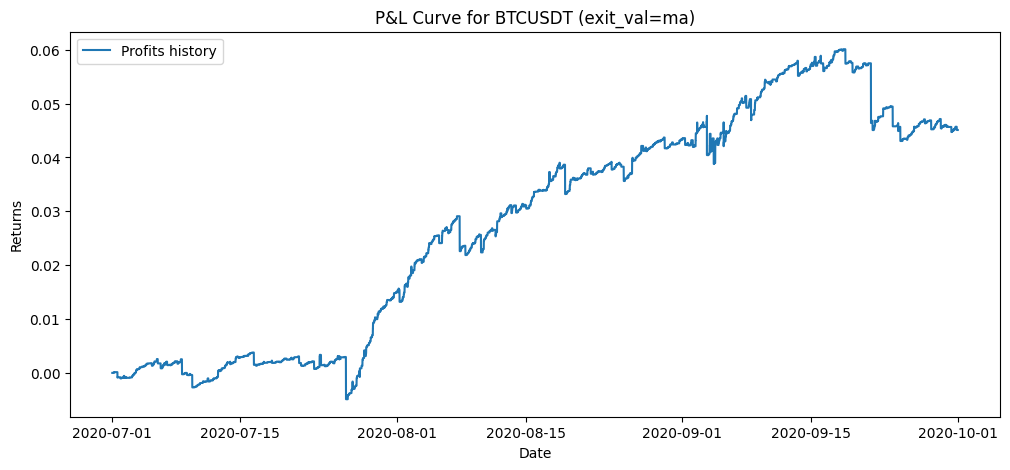

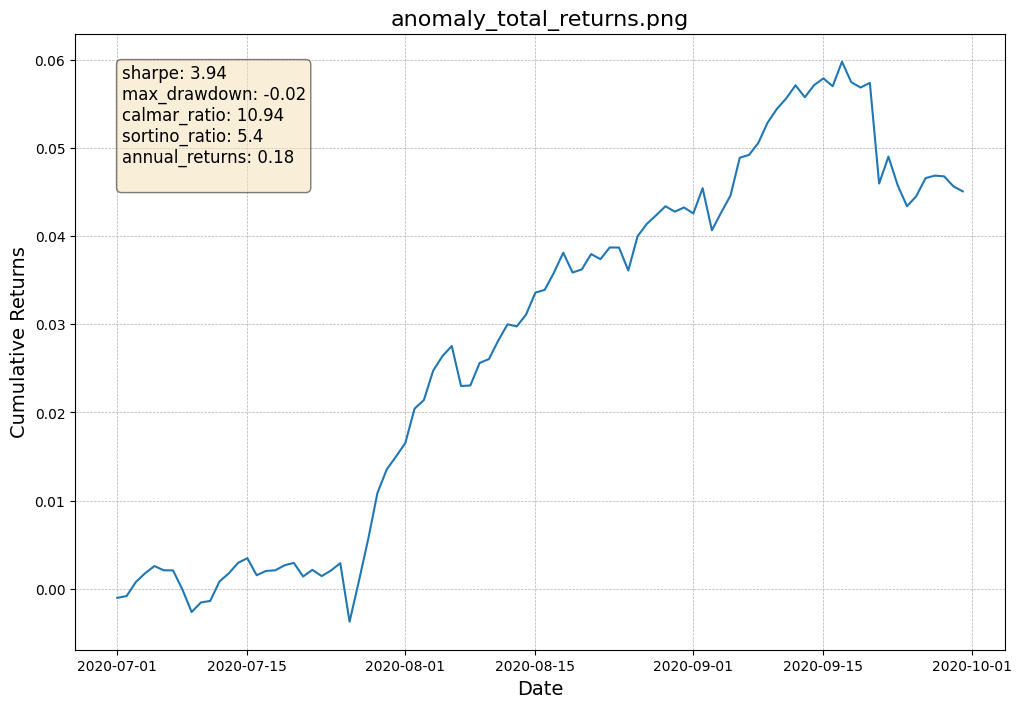

In [10]:
# for filename in os.listdir(preds_path):
#     if filename.endswith("_combined_scores_3m_20202021full.npy"):
#         model_name = filename.replace("_combined_scores_3m_20202021full.npy", "")
#         combined_scores[model_name] = np.load(
#             preds_path + filename, allow_pickle=True
#         )
#         print(f"Loaded combined_scores for {model_name} from {filename}")

# for filename in os.listdir(preds_path):
#     if filename.endswith("_combined_preds_3m.npy"):
#         model_name = filename.replace("_combined_preds_3m.npy", "")
#         combined_predictions[model_name] = np.load(
#             preds_path + filename, allow_pickle=True
#         )
#         print(f"Loaded combined_predictions for {model_name} from {filename}")

dates = pd.to_datetime(combined_test_dates)
df = pd.DataFrame(index=dates)
df.index.name = "datetime"

df["close"] = original_prices_buffer
df["scaled_price"] = scaled_prices
df["scores"] = combined_scores["autoencoder"]

df["predicted_price"] = combined_predictions["autoencoder"]

data_dict = {"BTCUSDT": df}

best_params = {
    "num_std": 3,
    "num_std_exit": 3,
    "percentile": 95,
    "exit_val": "ma",
    "max_entries": 10,
    "distr_len": 34,
    "ma_window_short": 89,
    "ma_window_long": 200,
    "window_size_minutes": 100,
    "RSI_window_minutes": 55,
    "rsi_entry": "30,70",
    "rsi_exit": "30,70",
    "plot_pl": True,
    "print_trades": True,
    "comission_rate": 0.0002,
    "with_short": True,
}

# start_date = "2021-06-01"
# end_date = "2021-12-31"

# data_dict["BTCUSDT"] = data_dict["BTCUSDT"].loc[start_date:end_date]

# results, closed_trades, rolling_anomalies = calc_pl(data_dict, best_params)

# print(calculate_sharpe_ratio(results))

params = {
    "num_std": [1, 2, 3],
    "num_std_exit": [1, 2, 3],
    "percentile": [75, 90, 95, 99],
    "exit_val": ["rsi", "ma"],  # or "ma"
    "max_entries": [5, 10, 20],
    "plot_pl": False,
    "distr_len": [34, 144],
    "RSI_window_minutes": [55, 89],
    "Ma_window_short": [34, 89],
    "Ma_window_long": [200, 500],
    "window_size_minutes": [100, 1000, 5000],
    "rsi_entry": ["30,70", "40,60"],
    "rsi_exit": ["30,70", "40,60", "50,50"],
    "print_trades": False,
    "comission_rate": 0.0002,
    "with_short": [True, False],
}

# save_path = "/Users/alexanderdemachev/PycharmProjects/strategy/aq/portfolio_optimization/market_regimes/trading_models/anomaly/results/"
save_path = "results/"
file_prefix = f"anomaly_"

optimizer = ParameterOptimizer(
    calc_pl, save_path=save_path, save_file_prefix=file_prefix, n_jobs=5
)

# optimizer.split_data(data_dict, "2021-06-01")
# optimizer.optimize(
#     data_dict=data_dict,
#     params=params,
#     n_runs=64,
#     best_trials_pct=0.1,
#     n_splits=3,
#     n_test_splits=1,
# )
optimizer.plot_returns(data_dict, best_params)

,open,high,low,close,volume,symbol,open time,asset volume,number of trades,taker buy base asset volume,taker buy quote asset volume,scaled_price
datetime,,,,,,,,,,,,
2024-12-24 06:33:00,94349.4,94368.7,94329.9,94358.8,4.277121e+06,BTCUSDT,2024-12-24 06:32:00,45.331,1161.0,26.199,2.471893e+06,0.612796
2024-12-24 06:34:00,94358.8,94360.1,94313.1,94313.3,2.704642e+06,BTCUSDT,2024-12-24 06:33:00,28.668,821.0,14.598,1.377329e+06,0.597483
2024-12-24 06:35:00,94313.2,94341.8,94301.7,94328.4,2.290662e+06,BTCUSDT,2024-12-24 06:34:00,24.286,1075.0,15.319,1.444955e+06,0.602565
2024-12-24 06:36:00,94328.3,94361.0,94328.3,94350.1,2.533146e+06,BTCUSDT,2024-12-24 06:35:00,26.850,854.0,20.658,1.948942e+06,0.609868
2024-12-24 06:37:00,94350.1,94360.8,94342.9,94360.8,9.965444e+05,BTCUSDT,2024-12-24 06:36:00,10.562,280.0,6.806,6.421635e+05,0.613469
